In [1]:
%pip install davos
import davos

davos.config.suppress_stdout = True

Note: you may need to restart the kernel to use updated packages.


In [2]:
smuggle datawrangler as dw        # pip: pydata-wrangler==0.2.2

smuggle numpy as np               # pip: numpy==1.24.2
smuggle matplotlib.pyplot as plt  # pip: matplotlib==3.7.0
from matplotlib.patches smuggle Rectangle
smuggle pandas as pd              # pip: pandas==1.5.3
smuggle seaborn as sns            # pip: seaborn==0.12.2
from skimage smuggle transform    # pip: scikit-image==0.20.0

from sklearn.decomposition smuggle IncrementalPCA as PCA      # pip: scikit-learn==1.2.1
from sklearn.linear_model smuggle LinearRegression
from scipy.spatial.distance smuggle cdist                     # pip: scipy==1.10.1
from scipy.stats import ttest_1samp, ttest_rel

smuggle nilearn as nl             # pip: nilearn==0.10.0
smuggle nibabel as nib            # pip: nibabel==5.0.1

from tqdm smuggle tqdm            # pip: tqdm==4.64.1

smuggle requests                  # pip: requests==2.28.2

from statsmodels.stats.multitest smuggle multipletests        # pip: statsmodels==0.14.0

import os
import pickle

from helpers import group_pca, cross_validation, ridge_plot, conditions, condition_colors, basedir, datadir, figdir, scratch_dir, get_data, info_and_compressibility, plot_info_and_compressibility_scatter, plot_accuracy, pstring

Download and load data

In [3]:
data = get_data()

Load (computing and saving as needed) the reduced versions of the data using $k \in \{3, 4, 5, ..., 700\}$ components

In [4]:
reduced_data = {'full': {}}
max_components = data['weights']['intact'][0].shape[1]

n_parts = 4
for i in range(n_parts):
    reduced_data[f'pt{i}'] = {}

for c in conditions:
    reduced_data['full'][c] = {}

    for i in range(n_parts):
        reduced_data[f'pt{i}'][c] = {}
    
    chunk_size = data['weights'][c][0].shape[0] // n_parts

    for n in tqdm(range(3, max_components + 1)):
        # full time range
        fname = os.path.join(scratch_dir, f'pca_full_{c}_{n}.pkl')
        reduced_data['full'][c][n], _ = group_pca(data['weights'][c], n_components=n, fname=fname)
        
        # chunked time range
        for i in range(n_parts):
            fname = os.path.join(scratch_dir, f'pca_pt{i + 1}_of_{n_parts}_{c}_{n}.pkl')
            chunk_start = i * chunk_size
            if i < n_parts - 1:                
                chunk_end = (i + 1) * chunk_size
            else:
                chunk_end = data['weights'][c][0].shape[0]
            
            next_chunk = [x.iloc[chunk_start:chunk_end] for x in data['weights'][c]]
            reduced_data[f'pt{i}'][c][n], _ = group_pca(next_chunk, n_components=n, fname=fname)
    
    data['weights'].pop(c)


  0%|          | 0/698 [00:00<?, ?it/s]

100%|██████████| 698/698 [00:42<00:00, 16.51it/s]


In [5]:
n_iter = 100

decoding_results = {'full': {}}
for i in range(n_parts):
    decoding_results[f'pt{i}'] = {}

for c in conditions:
    # full time range
    fname = os.path.join(scratch_dir, f'decoding_results_{n_iter}_full_{c}.pkl')
    decoding_results['full'][c] = cross_validation(reduced_data['full'][c], n_iter=n_iter, fname=fname)

    # chunked time range
    for i in range(n_parts):
        fname = os.path.join(scratch_dir, f'decoding_results_{n_iter}_pt{i + 1}_of_{n_parts}_{c}.pkl')
        decoding_results[f'pt{i}'][c] = cross_validation(reduced_data[f'pt{i}'][c], n_iter=n_iter, fname=fname)

# Figure 2A

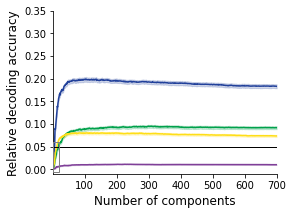

In [6]:
fig = plot_accuracy(decoding_results['full']);
ax = plt.gca()

ax.plot([0, 700], [0.05, 0.05], '-', color='black', linewidth=1)
ax.add_patch(Rectangle((3, -0.005), 17, 0.065, fill=False, edgecolor='gray', linewidth=1, zorder=3))

fig.savefig(os.path.join(figdir, 'decoding_full.pdf'), bbox_inches='tight')


# Figure 2B

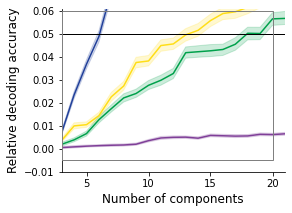

In [7]:
fig = plot_accuracy(decoding_results['full']);
ax = plt.gca()

ax.plot([0, 700], [0.05, 0.05], '-', color='black', linewidth=1)
ax.add_patch(Rectangle((3, -0.005), 17, 0.065, fill=False, edgecolor='gray', linewidth=1, zorder=3))
ax.set_xlim(3, 21)
ax.set_ylim(-0.01, 0.061)

fig.savefig(os.path.join(figdir, 'decoding_full_zoomed.pdf'), bbox_inches='tight')

# Figure 2C

In [28]:
def info_and_compressibility(d, target=None):
    def closest(x, target):
        dists = np.abs(x.values - target)
        dists[x.values < target] += 10 * np.max(dists)
        return int(x.index.values[np.argmin(dists)])

    df = []
    for c in conditions:
        dc = d[c].astype(float).pivot(index='Iteration', columns='Number of components', values='Relative decoding accuracy')
        i = pd.DataFrame()

        if target is None:
            i['Number of components'] = dc.idxmax(axis=1).astype(int)
        else:
            i['Number of components'] = dc.apply(lambda x: closest(x, target), axis=1, raw=False)
        i['Relative decoding accuracy'] = dc.max(axis=1)
        i['Condition'] = c
        i['Iteration'] = dc.index.values.astype(int)
        df.append(i)
    return pd.concat(df, ignore_index=True, axis=0)

In [107]:
def ridge_plot(x, column='Number of components', fname=None, xlim=[-99, 700], hue='Condition', palette=[condition_colors[c] for c in conditions], scale_start=0.25, scale_height=0.1):

    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
    g = sns.FacetGrid(x, row=hue, hue=hue, palette=palette, height=1, aspect=6)
    g.map(sns.kdeplot, column, bw_adjust=1, clip_on=True, fill=True, alpha=1, common_norm=True, linewidth=1.5)  # REPLACE WITH A NEW FUNCTION THAT NORMALIZES AREA TO 1
    g.refline(y=0, linewidth=1.5, linestyle='-', color=None, clip_on=False)

    # plot a scale bar in the upper right
    if scale_height is not None:        
        # compute the x position of the scale bar -- 98% of the way to the right
        x = xlim[0] + 0.98 * (xlim[1] - xlim[0])    
        g.axes[0][0].plot([x, x], [scale_start, scale_start + scale_height], color='k', linewidth=1.5)

    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, 0.2, label.capitalize(), color=color, ha='left', va='center', transform=ax.transAxes)

    g.map(label, hue)

    g.figure.subplots_adjust(hspace=-0.5)
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)

    fig = plt.gcf()
    fig.set_size_inches(4, 3)

    ax = plt.gca()
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_xlabel(column, fontsize=12)    

    if fname is not None:
        g.savefig(os.path.join(figdir, fname + '.pdf'), bbox_inches='tight')

    return fig

In [38]:
x1 = info_and_compressibility(decoding_results['full'], target=0.05)
x2 = info_and_compressibility(decoding_results['full'])

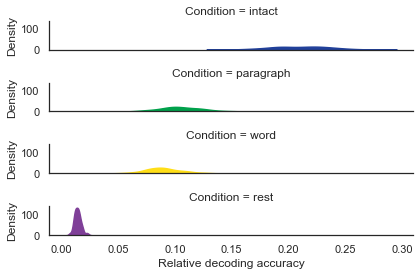

In [66]:
column = 'Relative decoding accuracy'
hue = 'Condition'
palette=[condition_colors[c] for c in conditions]

g = sns.FacetGrid(x1, row=hue, hue=hue, palette=palette, height=1, aspect=6)
g.map(sns.kdeplot, column, bw_adjust=1, clip_on=True, fill=True, alpha=1, common_norm=True, linewidth=1.5, bw_method='scott')

In [99]:
data = [x for x in g.facet_data()]
data = [b for a, b in data if b.shape[0] > 0]

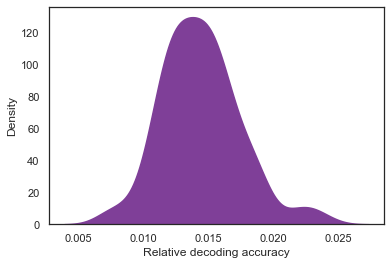

In [109]:
h = sns.kdeplot(data=data[3], x='Relative decoding accuracy', bw_adjust=1, clip_on=True, fill=True, alpha=1, common_norm=True, linewidth=1.5, bw_method='scott', color=palette[3])

In [102]:
data[1]

,Number of components,Relative decoding accuracy,Condition,Iteration
100,25,0.101103,paragraph,0
101,20,0.117647,paragraph,1
102,13,0.119485,paragraph,2
103,15,0.102941,paragraph,3
104,24,0.093750,paragraph,4
...,...,...,...,...
195,19,0.106618,paragraph,95
196,20,0.108456,paragraph,96
197,40,0.097426,paragraph,97
198,23,0.106618,paragraph,98


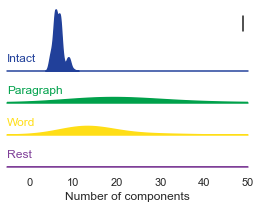

In [108]:
ridge_plot(info_and_compressibility(decoding_results['full'], target=0.05), column='Number of components', xlim=[-5, 50], fname='n_components_dists_full', scale_start=0.25, scale_height=0.1);

# Figure 2D

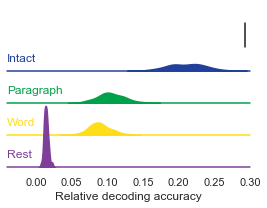

In [34]:
ridge_plot(info_and_compressibility(decoding_results['full']), column='Relative decoding accuracy', xlim=[-0.04, 0.3], fname='decoding_accuracy_dists_full', scale_start=50, scale_height=50);

In [11]:
info_and_compressibility(decoding_results['full'], target=1.0)

,Number of components,Relative decoding accuracy,Condition,Iteration
0,66,0.181667,intact,0
1,257,0.236667,intact,1
2,197,0.188333,intact,2
3,40,0.243333,intact,3
4,82,0.166667,intact,4
...,...,...,...,...
395,279,0.012500,rest,95
396,139,0.008750,rest,96
397,154,0.015000,rest,97
398,59,0.012500,rest,98


In [23]:
info_and_compressibility(decoding_results['full'], target=0.05)

,Number of components,Relative decoding accuracy,Condition,Iteration
0,9,0.181667,intact,0
1,7,0.236667,intact,1
2,7,0.188333,intact,2
3,6,0.243333,intact,3
4,9,0.166667,intact,4
...,...,...,...,...
395,279,0.012500,rest,95
396,139,0.008750,rest,96
397,154,0.015000,rest,97
398,59,0.012500,rest,98


# Figure 2E

In [14]:
fig = plot_info_and_compressibility_scatter(decoding_results['full'], target=1.0);
ax = plt.gca()
ax.add_patch(Rectangle((3, -0.005), 72, 0.3, fill=False, edgecolor='gray', linewidth=1, zorder=3))

fig.savefig(os.path.join(figdir, 'decoding_full_scatter.pdf'), bbox_inches='tight')


TypeError: plot_info_and_compressibility_scatter() got an unexpected keyword argument 'target'

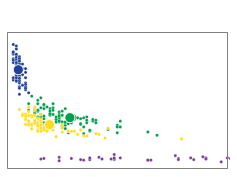

In [ ]:
ax.set_xlim(3, 76)
ax.set_axis_off()
fig.savefig(os.path.join(figdir, 'decoding_full_scatter_inset.pdf'), bbox_inches='tight')
fig


# Figure 3A

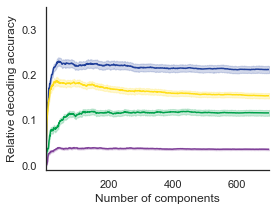

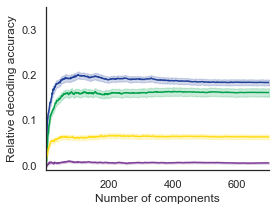

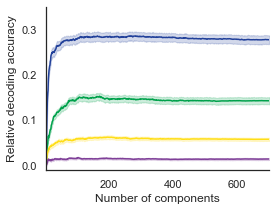

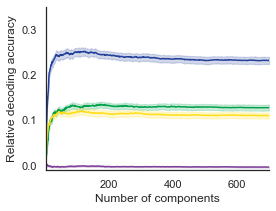

In [ ]:
for i in range(n_parts):
    plot_accuracy(decoding_results[f'pt{i}'], fname=f'decoding_pt{i + 1}_of_{n_parts}', figdir=figdir);

# Figure 3B

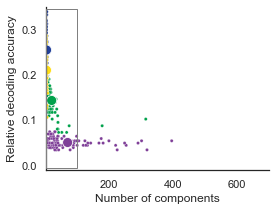

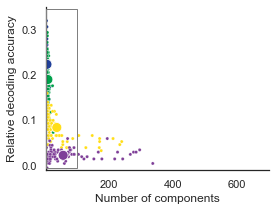

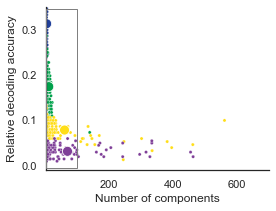

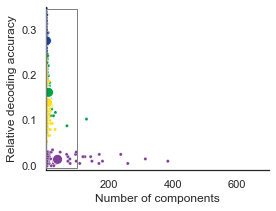

In [ ]:
for i in range(n_parts):
    fig = plot_info_and_compressibility_scatter(decoding_results[f'pt{i}']);
    ax = plt.gca()
    ax.add_patch(Rectangle((3, -0.005), 97, 0.35, fill=False, edgecolor='gray', linewidth=1, zorder=3))

    fig.savefig(os.path.join(figdir, f'decoding_pt{i + 1}_of_{n_parts}_scatter.pdf'), bbox_inches='tight')



# Fig 3B insets

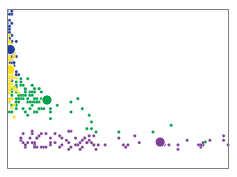

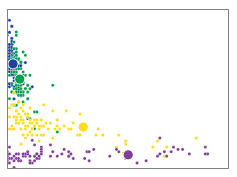

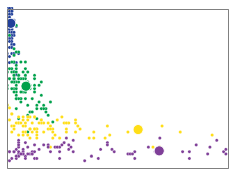

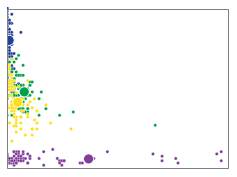

In [ ]:
for i in range(n_parts):
    fig = plot_info_and_compressibility_scatter(decoding_results[f'pt{i}']);
    ax = plt.gca()
    ax.add_patch(Rectangle((3, -0.005), 97, 0.35, fill=False, edgecolor='gray', linewidth=1, zorder=3))

    ax.set_xlim(3, 101)
    ax.set_axis_off()
    fig.savefig(os.path.join(figdir, f'decoding_pt{i + 1}_of_{n_parts}_scatter_inset.pdf'), bbox_inches='tight')
    fig


# Change analysis (Fig 3C)

In [ ]:
def accuracy_slopes(parts, fname=None):
    if fname is not None:
        if os.path.exists(fname):
            with open(fname, 'rb') as f:
                return pickle.load(f)

    components = np.unique(parts[0]['intact']['Number of components']).astype(int)
    iterations = np.unique(parts[0]['intact']['Iteration']).astype(int)
    df = []

    x = np.arange(len(parts)).reshape(-1, 1)

    for c in conditions:
        for i in tqdm(iterations):
            for n in components:
                y = []
                for p in parts:
                    y.append(p[c].query('Iteration == @i & `Number of components` == @n')['Relative decoding accuracy'].values.astype(float))
                y = np.array(y).reshape(-1, 1)

                # note: I'm not sure why the commented out code below doesn't work, whereas the above does...
                # y = pd.concat([p[c].query('Iteration == @i & `Number of components` == @n') for p in parts], axis=0).copy()['Relative decoding accuracy'].values.astype(float).reshape(-1, 1)

                regression = LinearRegression().fit(x, y)
                
                r = pd.Series(dtype=float)
                r['Number of components'] = n
                r['Slope'] = float(regression.coef_)
                r['Condition'] = c
                r['Iteration'] = i
                
                df.append(pd.DataFrame(r).T)
    
    df = pd.concat(df, ignore_index=True, axis=0)

    if fname is not None:
        with open(fname, 'wb') as f:
            pickle.dump(df, f)
    
    return df

In [ ]:
slopes = accuracy_slopes([decoding_results[f'pt{i}'] for i in range(n_parts)], fname=os.path.join(scratch_dir, f'decoding_slopes_{n_iter}.pkl'))

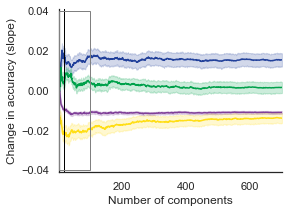

In [ ]:
fig = plt.figure(figsize=(4, 3))
ax = plt.gca()

sns.lineplot(slopes, x='Number of components', y='Slope', hue='Condition', palette=[condition_colors[c] for c in conditions], legend=False)

ax.set_xlabel('Number of components', fontsize=12)
ax.set_ylabel('Change in accuracy (slope)', fontsize=12)
ax.plot([20, 20], [-0.05, 0.05], '-', color='black', linewidth=1)
ax.set_ylim(-0.041, 0.041)
ax.set_xlim(3, 700)
ax.spines[['right', 'top']].set_visible(False)

ax.add_patch(Rectangle((3, -0.04), 97, 0.08, fill=False, edgecolor='gray', linewidth=1, zorder=3))

fig.savefig(os.path.join(figdir, 'decoding_slopes.pdf'), bbox_inches='tight')

# Fig 3C inset

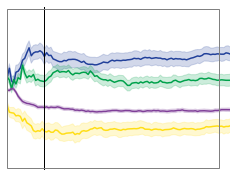

In [ ]:
ax.set_xlim([3, 105])
ax.set_axis_off()
fig.savefig(os.path.join(figdir, 'decoding_slopes_zoomed.pdf'), bbox_inches='tight')
fig

# Figure S1

In [ ]:
segments = ['full']
for i in range(n_parts):
    segments.append(f'pt{i}')
var_explained = {k: pd.DataFrame(index=pd.MultiIndex.from_product([range(3, max_components + 1), conditions], names=['Number of components', 'Condition']), columns=['Cumulative variance explained']) for k in segments}

for c in conditions:
    for n in tqdm(range(3, max_components + 1)):
        # full
        fname = os.path.join(scratch_dir, f'pca_full_{c}_{n}.pkl')
        _, model = group_pca([], n_components=n, fname=fname)
        var_explained['full'].loc[(n, c), 'Cumulative variance explained'] = model.explained_variance_ratio_.sum()

        # parts
        for i in range(n_parts):
            fname = os.path.join(scratch_dir, f'pca_pt{i + 1}_of_{n_parts}_{c}_{n}.pkl')
            
            _, model = group_pca([], n_components=n, fname=fname)
            var_explained[f'pt{i}'].loc[(n, c), 'Cumulative variance explained'] = model.explained_variance_ratio_.sum()            

100%|██████████| 698/698 [00:19<00:00, 36.25it/s]


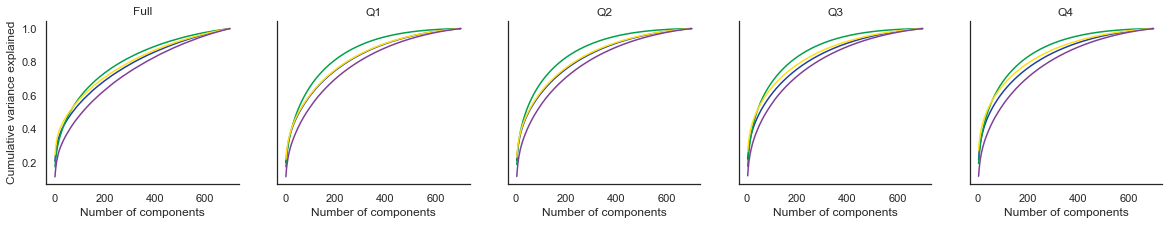

In [ ]:
fig, ax = plt.subplots(1, n_parts + 1, figsize=(4 + n_parts * 4, 3), sharex=True, sharey=True)
sns.lineplot(var_explained['full'].reset_index(), x='Number of components', y='Cumulative variance explained', hue='Condition', palette=[condition_colors[c] for c in conditions], legend=False, ax=ax[0])
ax[0].set_title('Full', fontsize=12)
ax[0].set_xlabel('Number of components', fontsize=12)
ax[0].set_ylabel('Cumulative variance explained', fontsize=12)
ax[0].spines[['right', 'top']].set_visible(False)

for i in range(n_parts):
    sns.lineplot(var_explained[f'pt{i}'].reset_index(), x='Number of components', y='Cumulative variance explained', hue='Condition', palette=[condition_colors[c] for c in conditions], legend=False, ax=ax[i + 1])
    ax[i + 1].set_title(f'Q{i + 1}', fontsize=12)
    ax[i + 1].set_xlabel('Number of components', fontsize=12)
    ax[i + 1].spines[['right', 'top']].set_visible(False)

fig.savefig(os.path.join(figdir, 'pca_variance_explained.pdf'), bbox_inches='tight')

# Stats!

Use t-tests to compare peak decoding accuracy across different conditions (across cross-validation runs):
- intact vs. paragraph, intact vs. word, intact vs. rest
- paragraph vs. word, paragraph vs. rest
- word vs. rest

Note: for these tests (and all tests below):
  - All $t$-tests are two-sided
  - Use the [Benjamini/Hochberg procedure](https://www.statsmodels.org/dev/generated/statsmodels.stats.multitest.multipletests.html) to correct for multiple comparisons-- this method controls for the false discovery rate (as opposed to Bonferroni correction and others, which correct for the family-wise error rate)

In [ ]:
x = info_and_compressibility(decoding_results['full'])
x

,Number of components,Relative decoding accuracy,Condition,Iteration
0,9,0.181667,intact,0
1,7,0.236667,intact,1
2,7,0.188333,intact,2
3,6,0.243333,intact,3
4,9,0.166667,intact,4
...,...,...,...,...
395,279,0.012500,rest,95
396,139,0.008750,rest,96
397,154,0.015000,rest,97
398,59,0.012500,rest,98


In [ ]:
accuracy_comparisions = []

for c1 in conditions:
    for c2 in conditions:
        if c1 == c2:
            continue
        
        results = ttest_rel(x.query('Condition == @c1')['Relative decoding accuracy'], x.query('Condition == @c2')['Relative decoding accuracy'])
        accuracy_comparisions.append(pd.DataFrame.from_records([{'Condition 1': c1, 'Condition 2': c2, 't': results.statistic, 'df': results.df, 'p': results.pvalue}]))        

# correct for multiple comparisons
accuracy_comparisions = pd.concat(accuracy_comparisions, ignore_index=True, axis=0)
accuracy_comparisions['p (corrected)'] = multipletests(accuracy_comparisions['p'], method='fdr_bh')[1]

# print results for easy copy-pasting into manuscript
for i, row in accuracy_comparisions.iterrows():
    print(f'{row["Condition 1"]} vs. {row["Condition 2"]}: $t({row["df"]:.0f}) = {row["t"]:.2f}, {pstring(row["p (corrected)"])}$')

intact vs. paragraph: $t(99) = 35.21, p < 0.001$
intact vs. word: $t(99) = 43.17, p < 0.001$
intact vs. rest: $t(99) = 81.36, p < 0.001$
paragraph vs. intact: $t(99) = -35.21, p < 0.001$
paragraph vs. word: $t(99) = 6.24, p < 0.001$
paragraph vs. rest: $t(99) = 50.75, p < 0.001$
word vs. intact: $t(99) = -43.17, p < 0.001$
word vs. paragraph: $t(99) = -6.24, p < 0.001$
word vs. rest: $t(99) = 48.79, p < 0.001$
rest vs. intact: $t(99) = -81.36, p < 0.001$
rest vs. paragraph: $t(99) = -50.75, p < 0.001$
rest vs. word: $t(99) = -48.79, p < 0.001$


In [ ]:
# display table
accuracy_comparisions

,Condition 1,Condition 2,t,df,p,p (corrected)
0,intact,paragraph,35.205328,99,8.650991e-58,1.038119e-57
1,intact,word,43.171511,99,5.021579e-66,7.532368e-66
2,intact,rest,81.361428,99,1.736060e-92,1.041636e-91
3,paragraph,intact,-35.205328,99,8.650991e-58,1.038119e-57
4,paragraph,word,6.243288,99,1.072637e-08,1.072637e-08
5,paragraph,rest,50.747565,99,1.116785e-72,3.350355e-72
6,word,intact,-43.171511,99,5.021579e-66,7.532368e-66
7,word,paragraph,-6.243288,99,1.072637e-08,1.072637e-08
8,word,rest,48.791223,99,4.719437e-71,9.438874e-71
9,rest,intact,-81.361428,99,1.736060e-92,1.041636e-91


for each "story" condition (intact, paragraph, and word), and for each cross-validation run, compute the number of components where each "decoding accuracy as a function of number of components" curve first exceeds the 5% decoding accuracy threshold marked in 2B

use t-tests to compare the numbers of components across conditions:
- intact vs. paragraph, intact vs. word
- paragraph vs. word

In [ ]:
components_comparisons = []

for c1 in conditions:
    if c1 == 'rest':
        continue

    for c2 in conditions:
        if c2 == 'rest':
            continue
        elif c1 == c2:
            continue

        results = ttest_rel(x.query('Condition == @c1')['Number of components'], x.query('Condition == @c2')['Number of components'])
        components_comparisons.append(pd.DataFrame.from_records([{'Condition 1': c1, 'Condition 2': c2, 't': results.statistic, 'df': results.df, 'p': results.pvalue}]))

# correct for multiple comparisons
components_comparisons = pd.concat(components_comparisons, ignore_index=True, axis=0)
components_comparisons['p (corrected)'] = multipletests(components_comparisons['p'], method='fdr_bh')[1]

# print results for easy copy-pasting into manuscript
for i, row in components_comparisons.iterrows():
    print(f'{row["Condition 1"]} vs. {row["Condition 2"]}: $t({row["df"]:.0f}) = {row["t"]:.2f}, {pstring(row["p (corrected)"])}$')

intact vs. paragraph: $t(99) = -7.43, p < 0.001$
intact vs. word: $t(99) = -7.30, p < 0.001$
paragraph vs. intact: $t(99) = 7.43, p < 0.001$
paragraph vs. word: $t(99) = 2.46, p = 0.016$
word vs. intact: $t(99) = 7.30, p < 0.001$
word vs. paragraph: $t(99) = -2.46, p = 0.016$


In [ ]:
# display table
components_comparisons

,Condition 1,Condition 2,t,df,p,p (corrected)
0,intact,paragraph,-7.428745,99,3.930166e-11,1.099820e-10
1,intact,word,-7.299933,99,7.332131e-11,1.099820e-10
2,paragraph,intact,7.428745,99,3.930166e-11,1.099820e-10
3,paragraph,word,2.459485,99,1.564778e-02,1.564778e-02
4,word,intact,7.299933,99,7.332131e-11,1.099820e-10
5,word,paragraph,-2.459485,99,1.564778e-02,1.564778e-02


Based on Fig. 3C-- i.e., the "inflection" figure:

t-tests comparing the change in decoding accuracy for n = 20 components (rightmost part of Fig 3C) to 0:
- intact
- paragraph
- word
- rest

In [ ]:
slopes

,Number of components,Slope,Condition,Iteration
0,3.0,0.004,intact,0
1,4.0,-0.019333,intact,0
2,5.0,-0.014,intact,0
3,6.0,-0.004667,intact,0
4,7.0,0.01,intact,0
...,...,...,...,...
279195,696.0,-0.006,rest,99
279196,697.0,-0.006,rest,99
279197,698.0,-0.006,rest,99
279198,699.0,-0.006,rest,99


In [ ]:
slope_comparisons = []

for c in conditions:
    results = ttest_1samp(slopes.query('Condition == @c & `Number of components` == 20')['Slope'].astype(float), 0)
    slope_comparisons.append(pd.DataFrame.from_records([{'Condition': c, 't': results.statistic, 'df': results.df, 'p': results.pvalue}]))

# correct for multiple comparisons
slope_comparisons = pd.concat(slope_comparisons, ignore_index=True, axis=0)
slope_comparisons['p (corrected)'] = multipletests(slope_comparisons['p'], method='fdr_bh')[1]

# print results for easy copy-pasting into manuscript
for i, row in slope_comparisons.iterrows():
    print(f'{row["Condition"]}: $t({row["df"]:.0f}) = {row["t"]:.2f}, {pstring(row["p (corrected)"])}$')

intact: $t(99) = 7.91, p < 0.001$
paragraph: $t(99) = 2.35, p = 0.021$
word: $t(99) = -10.75, p < 0.001$
rest: $t(99) = -22.08, p < 0.001$


In [ ]:
# display table
slope_comparisons

,Condition,t,df,p,p (corrected)
0,intact,7.914968,99,3.649114e-12,4.865485e-12
1,paragraph,2.353874,99,2.055430e-02,2.055430e-02
2,word,-10.746681,99,2.588334e-18,5.176669e-18
3,rest,-22.081464,99,4.938961e-40,1.975584e-39
